# TSNE Ripser


In [2]:
import glob
import json 
import os
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import random
from tqdm import tqdm 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams
import numpy as np


In [3]:

def convert_data_to_TSNE(data, num_output_dims=2):
    """
    Convert data to TSNE using the TSNE algorithm from scikit-learn
    """

    # Configure the t-SNE model
    tsne = TSNE(n_components=num_output_dims, init='pca', random_state=42)

    # Fit the model and transform the data
    tsne_result = tsne.fit_transform(data)

    return tsne_result



In [17]:

def count_connected_components(dataset, epsilon):
    """
    Count the number of connected components in a dataset using epsilon-radius balls.

    Args:
        dataset (torch.Tensor or np.ndarray): Dataset of shape (n_points, d).
        epsilon (float): Radius for epsilon-balls to determine connectivity.

    Returns:
        int: Number of connected components.
    """
    # Ensure data is in numpy format
    if isinstance(dataset, torch.Tensor):
        data = dataset.numpy()
    elif isinstance(dataset, np.ndarray):
        data = dataset
    else:
        raise ValueError("Dataset must be a torch.Tensor or np.ndarray")

    # Compute persistence diagram
    result = ripser(data, maxdim=0, thresh=epsilon)
    diagrams = result['dgms']
    diagram_h0 = diagrams[0]

    # Count connected components properly
    # Consider every birth-death pair where death time is infinity or greater than birth plus a small threshold
    num_components = np.sum(diagram_h0[:, 1] == np.inf)
    return num_components, diagrams



## Grabbing Data



In [5]:
data_path = "results/sampled_u_final_token_reps_top10000_yids679.json"
data_1024_path = "results/sampled_u_final_token_reps_top1024_yids679.json"
# load json 

if not os.path.exists(data_1024_path):
    data_json = json.load(open(data_path, "r"))
data_json = json.load(open(data_path, "r"))

data_json[0].keys()

dict_keys(['y', 'u_list', 'y_str', 'u_str_list', 'final_token_rep', 'x_0_str', 'x_0'])

In [7]:
len(data_json)

10000

In [8]:
# save the first 1024 to data_1024_path if it does not exist 
if not os.path.exists(data_1024_path):
    data_1024 = data_json[:1024]
    with open(data_1024_path, "w") as f:
        json.dump(data_1024, f)

In [9]:
# Open the file in write mode
with open("results/sampled_u_final_token_reps_top10000_yids679.jsonl", "w") as file:
    # Iterate over each dictionary in the list
    for item in tqdm(data_json):
        # Convert the dictionary to a JSON string
        json_string = json.dumps(item)
        
        # Write the JSON string to the file, followed by a newline
        file.write(json_string + "\n")

100%|██████████| 10000/10000 [14:33<00:00, 11.44it/s]


In [71]:
LAYER_NUM = -2
# construct dummy data -- [samples, features]
final_tok_reps_list = []

for data_el in tqdm(data_1024):
    final_tok_reps_list.append(torch.tensor(data_el['final_token_rep'][LAYER_NUM]))

print("final_tok_reps_list length: ", len(final_tok_reps_list))
print("final_tok_reps_list[0] length: ", len(final_tok_reps_list[0]))

final_tok_reps = torch.stack(final_tok_reps_list)
print("final_tok_reps shape: ", final_tok_reps.shape)



dummy_data = final_tok_reps
tsne_data = convert_data_to_TSNE(dummy_data.numpy(), num_output_dims=3)
print(tsne_data)
plt.rcParams.update({
    "text.usetex": False
})
# Plot the data
plt.scatter(tsne_data[:, 0], tsne_data[:, 1])
plt.show()


100%|██████████| 1024/1024 [00:00<00:00, 1716.76it/s]


final_tok_reps_list length:  1024
final_tok_reps_list[0] length:  4096
final_tok_reps shape:  torch.Size([1024, 4096])


[[ 10.329437    -0.1455616    3.3389883 ]
 [-14.60516     -1.6830963   -0.77733916]
 [ 15.08365      3.070462    -3.2912319 ]
 ...
 [ 14.186856     3.7089357    5.9656286 ]
 [  4.1806974   -4.5316052    0.46626118]
 [  0.41084987  -4.2565255    0.8514809 ]]


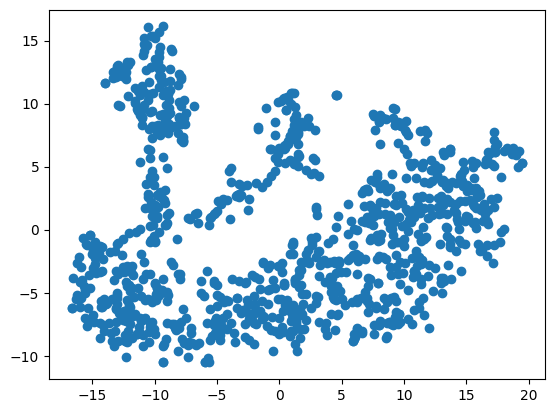

In [57]:
final_tok_reps_npy = final_tok_reps.numpy()

final_tok_reps_npy.shape

(1024, 4096)

In [58]:
np.linalg.norm(final_tok_reps_npy, axis=1)

array([152.89658, 156.13976, 151.01266, ..., 155.9816 , 153.75233,
       154.20561], dtype=float32)

In [59]:
cmp = []
diagrams = []

eps_max = 150
eps_step = 1

eps_range = np.arange(0, eps_max, eps_step)
print("Length of eps_range: ", len(eps_range))

for epsilon in tqdm(eps_range):
    cmp_, diagram = count_connected_components(final_tok_reps_npy, epsilon=epsilon)
    # cmp_, diagram = count_connected_components(final_tok_reps_npy, epsilon=epsilon)
    cmp += [cmp_]
    diagrams += [diagram]



Length of eps_range:  150


  0%|          | 0/150 [00:00<?, ?it/s]/home/user/Magic_Words/venv/lib/python3.10/site-packages/ripser/ripser.py:253: UserWarning:

The input point cloud has more columns than rows; did you mean to transpose?

  1%|          | 1/150 [00:00<00:20,  7.37it/s]/home/user/Magic_Words/venv/lib/python3.10/site-packages/ripser/ripser.py:253: UserWarning:

The input point cloud has more columns than rows; did you mean to transpose?

  1%|▏         | 2/150 [00:00<00:18,  8.06it/s]/home/user/Magic_Words/venv/lib/python3.10/site-packages/ripser/ripser.py:253: UserWarning:

The input point cloud has more columns than rows; did you mean to transpose?

  2%|▏         | 3/150 [00:00<00:18,  8.08it/s]/home/user/Magic_Words/venv/lib/python3.10/site-packages/ripser/ripser.py:253: UserWarning:

The input point cloud has more columns than rows; did you mean to transpose?

  3%|▎         | 4/150 [00:00<00:18,  8.09it/s]/home/user/Magic_Words/venv/lib/python3.10/site-packages/ripser/ripser.py:253: UserWarnin

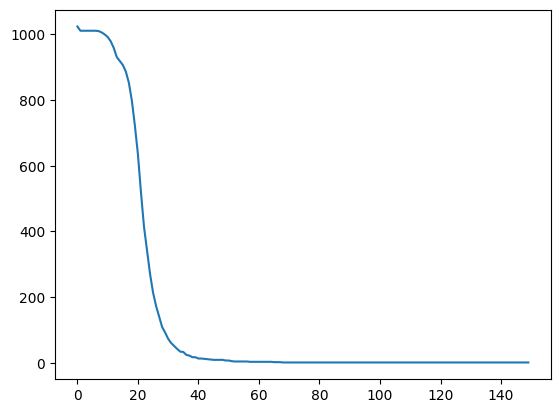

In [60]:
plt.plot(eps_range, cmp)
plt.show()

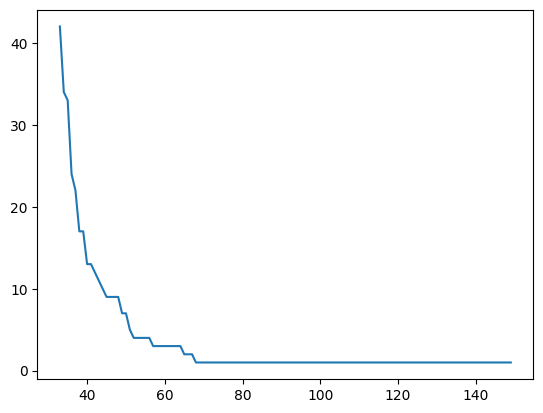

In [67]:
len(cmp)

max_num_conn = 50
msk = np.array(cmp) < max_num_conn

cmp = np.array(cmp)
#plot 
plt.plot(eps_range[msk], cmp[msk])
plt.show()

In [65]:
cmp[-100:]

array([7, 5, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [69]:
diagrams[-1]

[array([[0.00000000e+00, 3.81469727e-06],
        [0.00000000e+00, 5.39479652e-06],
        [0.00000000e+00, 5.39479652e-06],
        ...,
        [0.00000000e+00, 6.48455505e+01],
        [0.00000000e+00, 6.71593246e+01],
        [0.00000000e+00,            inf]])]

In [43]:
# 3d plotly scatter plot of the 3d t-SNE 
import plotly.express as px
import pandas as pd

tsne_data_df = pd.DataFrame(tsne_data, columns=["x", "y", "z"])

fig = px.scatter_3d(tsne_data_df, x='x', y='y', z='z')
fig.update_layout(title="3D t-SNE of final token representations")
# save figure to html 
fig.write_html("tsne_3d_20240625.html")
fig.show()